In [29]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import pandas as pd
import random

In [30]:
# Cell 2: AudioTransform class for data augmentation
class AudioTransform:
    def __init__(self, time_mask_prob=0.5, freq_mask_prob=0.5, time_stretch_prob=0.5):
        self.time_mask_prob = time_mask_prob
        self.freq_mask_prob = freq_mask_prob
        self.time_stretch_prob = time_stretch_prob
        
    def time_mask(self, mel_spec, max_mask_length=0.1):
        """Áp dụng time masking cho mel spectrogram"""
        if random.random() < self.time_mask_prob:
            # Lấy shape của mel spectrogram
            if len(mel_spec.shape) == 3:  # Nếu có channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Lấy channel đầu tiên
            else:
                n_mels, n_time = mel_spec.shape
                
            mask_length = int(n_time * max_mask_length)
            mask_start = random.randint(0, n_time - mask_length)
            mel_spec[:, mask_start:mask_start + mask_length] = 0
            
            if len(mel_spec.shape) == 2:  # Nếu ban đầu có channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
        return mel_spec
    
    def freq_mask(self, mel_spec, max_mask_length=0.1):
        """Áp dụng frequency masking cho mel spectrogram"""
        if random.random() < self.freq_mask_prob:
            # Lấy shape của mel spectrogram
            if len(mel_spec.shape) == 3:  # Nếu có channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Lấy channel đầu tiên
            else:
                n_mels, n_time = mel_spec.shape
                
            mask_length = int(n_mels * max_mask_length)
            mask_start = random.randint(0, n_mels - mask_length)
            mel_spec[mask_start:mask_start + mask_length, :] = 0
            
            if len(mel_spec.shape) == 2:  # Nếu ban đầu có channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
        return mel_spec
    
    def time_stretch(self, mel_spec, stretch_range=(0.8, 1.2)):
        """Áp dụng time stretching cho mel spectrogram"""
        if random.random() < self.time_stretch_prob:
            # Lấy shape của mel spectrogram
            if len(mel_spec.shape) == 3:  # Nếu có channel dimension
                _, n_mels, n_time = mel_spec.shape
                mel_spec = mel_spec[0]  # Lấy channel đầu tiên
            else:
                n_mels, n_time = mel_spec.shape
                
            stretch_factor = random.uniform(*stretch_range)
            new_time = int(n_time * stretch_factor)
            stretched = np.zeros((n_mels, new_time))
            
            for i in range(n_mels):
                stretched[i] = np.interp(
                    np.linspace(0, n_time, new_time),
                    np.arange(n_time),
                    mel_spec[i]
                )
            
            # Resize về kích thước ban đầu
            if stretch_factor > 1:
                # Nếu stretch > 1, cắt bớt
                mel_spec = stretched[:, :n_time]
            else:
                # Nếu stretch < 1, padding
                mel_spec = np.pad(stretched, ((0, 0), (0, n_time - new_time)))
                
            if len(mel_spec.shape) == 2:  # Nếu ban đầu có channel dimension
                mel_spec = np.expand_dims(mel_spec, axis=0)
                
        return mel_spec
    
    def __call__(self, mel_spec):
        """Áp dụng tất cả các augmentation"""
        mel_spec = self.time_mask(mel_spec)
        mel_spec = self.freq_mask(mel_spec)
        mel_spec = self.time_stretch(mel_spec)
        return mel_spec

In [31]:
# Cell 3: LoadData class for dataset handling
class LoadData(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        # Lọc bỏ metadata.csv khỏi danh sách classes
        self.classes = [d for d in sorted(os.listdir(data_dir)) 
                       if os.path.isdir(os.path.join(data_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.npy'):  # Đặc trưng mel spectrogram
                    self.samples.append((os.path.join(class_dir, file_name), self.class_to_idx[class_name]))
    
    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        features = np.load(file_path)
        
        if len(features.shape) == 2:
            features = np.expand_dims(features, axis=0)
            
        if self.transform:
            features = self.transform(features)
            
        return torch.FloatTensor(features), label

    def __len__(self):
        return len(self.samples)

In [32]:
# Cell 4: Create datasets and dataloaders
# Đọc metadata để chia train/test/val
metadata = pd.read_csv('../data/features/mel/metadata.csv')

# Tạo dataset với đường dẫn đầy đủ
base_dir = '../data/features/mel'

# Tạo transform cho augmentation
train_transform = AudioTransform(
    time_mask_prob=0.5,
    freq_mask_prob=0.5,
    time_stretch_prob=0.5
)

# Tạo dataset với augmentation cho training
full_ds = LoadData(base_dir, transform=train_transform)

# Chia dataset thành train (70%), val (15%), test (15%)
train_size = int(0.7 * len(full_ds))
val_size = int(0.15 * len(full_ds))
test_size = len(full_ds) - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(
    full_ds, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Đảm bảo tính tái lập
)

# Tạo DataLoader
batch_size = 32
dataloaders = {
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0),
    'val': DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0),
    'test': DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0),
}

# In thông tin về dataset
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples: {len(test_ds)}")
print(f"Number of classes: {len(full_ds.classes)}")
print(f"Classes: {full_ds.classes}")

Number of training samples: 574
Number of validation samples: 123
Number of test samples: 124
Number of classes: 12
Classes: ['bat_den', 'bat_dieu_hoa', 'bat_quat', 'bat_tv', 'do_am', 'dong_rem', 'mo_rem', 'nhiet_do', 'tat_den', 'tat_dieu_hoa', 'tat_quat', 'tat_tv']


In [33]:
# Cell 5: ConvMixer model definition
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=12):  # Sửa thành 12 classes
    return nn.Sequential(
        nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size),  # Input channel = 1 cho mel spectrogram
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=kernel_size, groups=dim, padding="same"),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            )),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [34]:
# Cell 6: Initialize model and training parameters
# Khởi tạo mô hình
model = ConvMixer(dim=256, depth=8, n_classes=12)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Kiểm tra và chuyển model lên GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Các tham số training
num_epochs = 20
patience = 5  # Số epoch chờ đợi trước khi early stopping
min_delta = 0.02  # Ngưỡng cải thiện tối thiểu

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.2,  # Giảm learning rate mạnh hơn
    patience=3,
    min_lr=1e-6  # Learning rate tối thiểu
)

# In thông tin về model và device
print(f"Model architecture:\n{model}")
print(f"Using device: {device}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Model architecture:
Sequential(
  (0): Conv2d(1, 256, kernel_size=(7, 7), stride=(7, 7))
  (1): GELU(approximate='none')
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Sequential(
    (0): Residual(
      (fn): Sequential(
        (0): Conv2d(256, 256, kernel_size=(9, 9), stride=(1, 1), padding=same, groups=256)
        (1): GELU(approximate='none')
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (2): GELU(approximate='none')
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Residual(
      (fn): Sequential(
        (0): Conv2d(256, 256, kernel_size=(9, 9), stride=(1, 1), padding=same, groups=256)
        (1): GELU(approximate='none')
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    

In [35]:
# Cell 7: Training loop
# Khởi tạo các list để lưu metrics
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Tính và lưu training loss
    epoch_train_loss = running_loss / len(dataloaders['train'])
    train_losses.append(epoch_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Tính và lưu validation metrics
    epoch_val_loss = val_loss / len(dataloaders['val'])
    val_acc = 100 * correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_acc)
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    # Cập nhật learning rate
    scheduler.step(val_acc)
    print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # Early stopping check
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        patience_counter = 0
        # Lưu model tốt nhất
        torch.save(model.state_dict(), '../data/models/audio_classifier_best.pth')
        print(f'New best model saved! Validation Accuracy: {val_acc:.2f}%')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs')
        
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

# Lưu model cuối cùng
torch.save(model.state_dict(), '../data/models/audio_classifier_final.pth')
print("Training completed!")

Epoch 1/20, Training Loss: 2.2081
Validation Loss: 2.7149, Validation Accuracy: 4.17%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 4.17%
Epoch 2/20, Training Loss: 1.7148
Validation Loss: 4.6972, Validation Accuracy: 14.58%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 14.58%
Epoch 3/20, Training Loss: 1.3911
Validation Loss: 4.0495, Validation Accuracy: 18.75%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 18.75%
Epoch 4/20, Training Loss: 1.2202
Validation Loss: 1.4673, Validation Accuracy: 54.17%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 54.17%
Epoch 5/20, Training Loss: 0.9445
Validation Loss: 0.9309, Validation Accuracy: 68.75%
Current learning rate: 0.001000
New best model saved! Validation Accuracy: 68.75%
Epoch 6/20, Training Loss: 0.7957
Validation Loss: 0.7641, Validation Accuracy: 72.92%
Current learning rate: 0.001000
New best model saved! Validation Accur

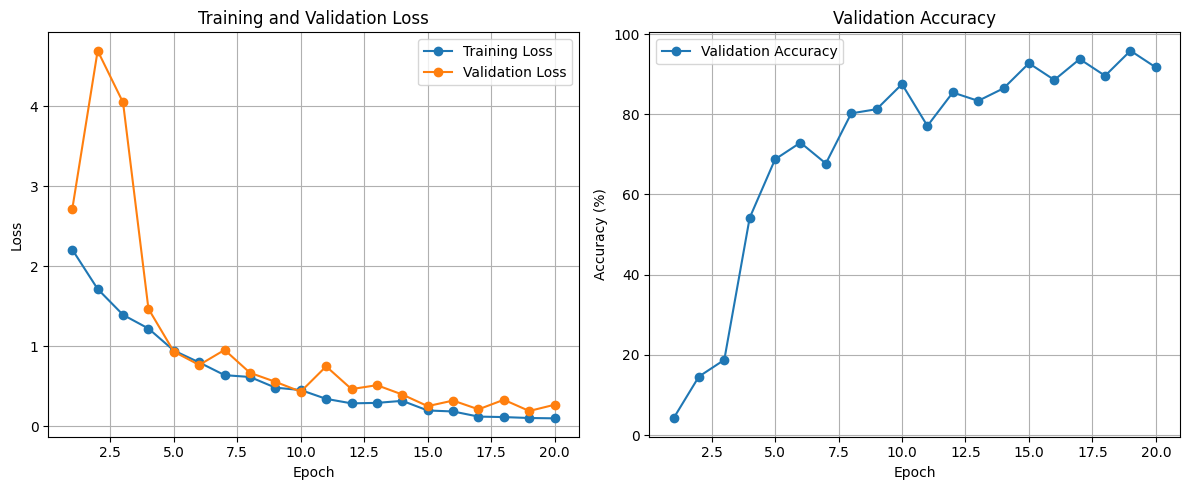

In [36]:
# Cell 8: Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test Loss: 0.2595
Test Accuracy: 92.71%


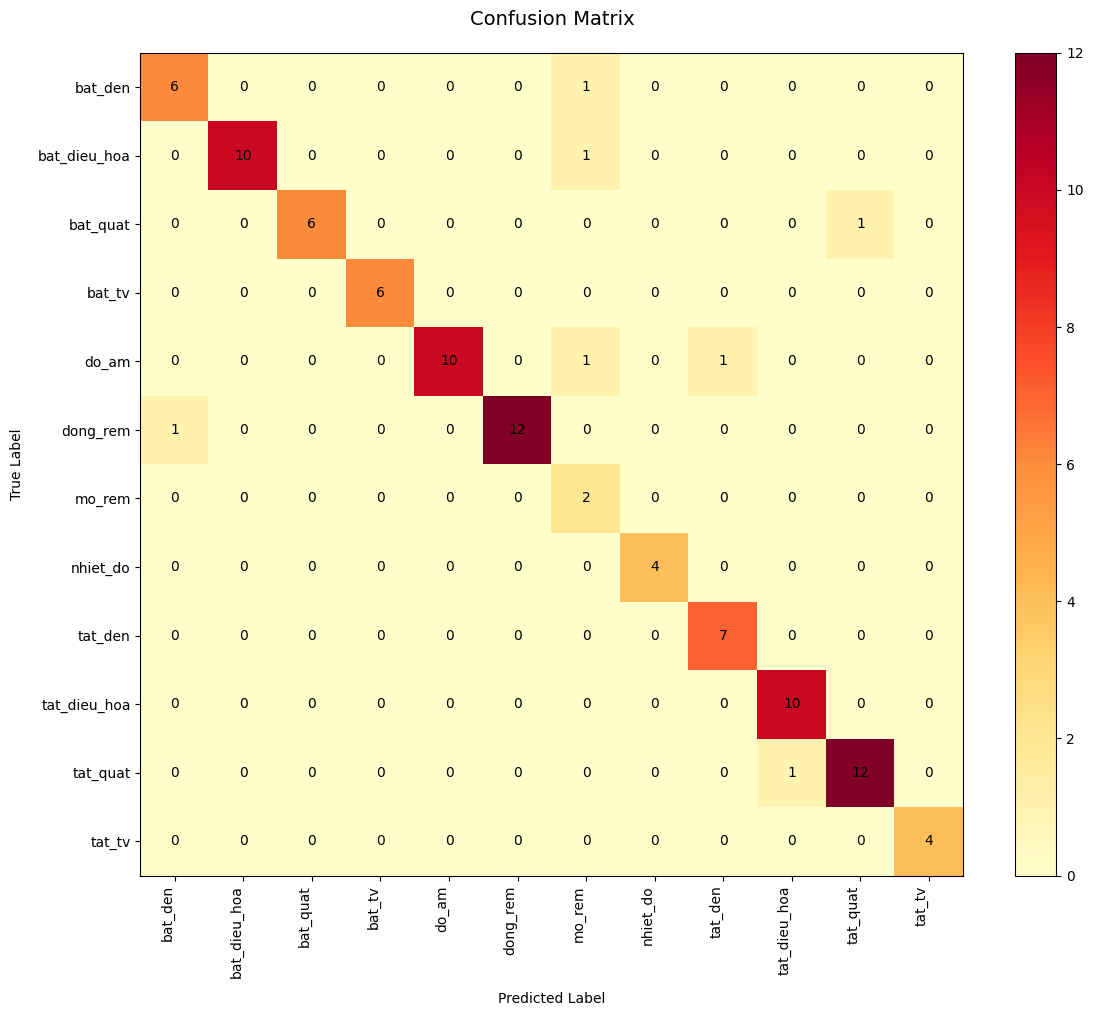


Classification Report:
              precision    recall  f1-score   support

     bat_den       0.86      0.86      0.86         7
bat_dieu_hoa       1.00      0.91      0.95        11
    bat_quat       1.00      0.86      0.92         7
      bat_tv       1.00      1.00      1.00         6
       do_am       1.00      0.83      0.91        12
    dong_rem       1.00      0.92      0.96        13
      mo_rem       0.40      1.00      0.57         2
    nhiet_do       1.00      1.00      1.00         4
     tat_den       0.88      1.00      0.93         7
tat_dieu_hoa       0.91      1.00      0.95        10
    tat_quat       0.92      0.92      0.92        13
      tat_tv       1.00      1.00      1.00         4

    accuracy                           0.93        96
   macro avg       0.91      0.94      0.92        96
weighted avg       0.95      0.93      0.93        96



In [47]:
# Cell 9: Evaluate on test set and plot confusion matrix
def evaluate_model(model, dataloader, criterion, device):
    """Đánh giá model trên tập test"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
    test_acc = 100 * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return avg_loss, test_acc, all_labels, all_predictions

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Vẽ confusion matrix"""
    plt.figure(figsize=(12, 10))
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=class_names
    )
    
    cm_display.plot(cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Load model tốt nhất
model.load_state_dict(torch.load('../data/models/audio_classifier_best.pth'))

# Đánh giá model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(
    model, dataloaders['test'], criterion, device
)

# In kết quả
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
confusion_matrix = metrics.confusion_matrix(all_labels, all_predictions)

# Vẽ heatmap
plt.imshow(confusion_matrix, cmap='YlOrRd')
plt.colorbar()

# Thêm giá trị vào từng ô
for i in range(len(full_ds.classes)):
    for j in range(len(full_ds.classes)):
        plt.text(j, i, f'{confusion_matrix[i, j]}',
                ha='center', va='center')

plt.title('Confusion Matrix', pad=20, fontsize=14)
plt.xlabel('Predicted Label', labelpad=10)
plt.ylabel('True Label', labelpad=10)

# Thêm labels
plt.xticks(range(len(full_ds.classes)), full_ds.classes, rotation=90, ha='right')
plt.yticks(range(len(full_ds.classes)), full_ds.classes)

plt.tight_layout()
plt.show()

# In classification report
print("\nClassification Report:")
print(metrics.classification_report(all_labels, all_predictions, target_names=full_ds.classes))